In [17]:
import matplotlib.pyplot as pl
import xarray as xr
import numpy as np
from datetime import datetime, timedelta


pl.rcParams['xtick.labelsize'] = 12
pl.rcParams['ytick.labelsize'] = 12
pl.rcParams['axes.labelsize'] = 16

output1=xr.open_dataset('/fs/ess/PFS0220/eurec4a/microhh_results/Dephy_Outputs/eurec4a_feb2_512_200m_12kmtop_6hrnudge.nc',decode_times=True)
output2=xr.open_dataset('/fs/ess/PFS0220/eurec4a/SAM_results/EUREC4A_2Feb_512sqx152_100m_SAM_NA250_kf.nc',decode_times=True)
output3=xr.open_dataset('/fs/ess/PFS0220/eurec4a/forcings/eurec4a_20200202_narenpitak_extended.kpt_inversion.nc',decode_times=True)


new_coords = xr.DataArray(output2['zf'].values, dims='height')
output2=output2.assign_coords({'height':new_coords})


output3=output3.rename({'sfc_sens_flx':'hfss','sfc_lat_flx':'hfls','open_sst':'ts','q':'qv','cloud_fraction':'flc','u':'ua','v':'va','msnswrf':'rss','msnlwrf':'rls','mtnswrf':'rst'})
output3['hfss']=output3['hfss']*-1; output3['hfls']=output3['hfls']*-1; output3['wspd']=np.sqrt((output3['ua'].isel(nlev=248))**2+(output3['va'].isel(nlev=248))**2)

if 'height_f' in output3.keys():
    new_coords = xr.DataArray(output3['height_f'].isel(time=0).values, dims='nlev')
else:
    new_coords = xr.DataArray(output3['zf'].isel(time=0).values, dims='nlev')
output3=output3.assign_coords({'nlev':new_coords})

output = {'MicroHH':output1,'SAM':output2}
output_3hr={'MicroHH':output1.resample(time='3H').mean(),'SAM':output2.resample(time='3H').mean()}
output_withERA5 = {'MicroHH':output1,'ERA5':output3,'SAM':output2}
output_3hr_withERA5={'MicroHH':output1.resample(time='3H').mean(),'ERA5':output3,'SAM':output2.resample(time='3H').mean()}

vars=['lwp','ps','pr']
vars_withERA5=['hfss','hfls','ts','wspd','rss','rls','rst']



def plot_1d(varname):
    pl.figure(figsize=(5, 5))
    for key in output:
        output[key][varname].plot.line(label=key)
    pl.legend(loc="upper center")
    pl.title(varname)

def plot_1d_withERA5(varname):
    pl.figure(figsize=(5, 5))
    for key in output_withERA5:
        output_withERA5[key][varname].plot.line(label=key)
    pl.legend(loc="upper center")
    pl.title(varname)

def plot_1d_from2d(varname,level):
    pl.figure()
    for key in output:
        (output[key].sel(zf=level))[varname].plot.line(label=key)
    pl.legend()
    pl.title(varname)

def plot_1d_timeavg(varname,with_ERA5=False):
    max_ht=130
    if with_ERA5:
        xr_data=output_3hr_withERA5
    else:   
        xr_data=output_3hr
    #start_time = datetime.fromisoformat(start_time)
    fig, axs = pl.subplots(nrows=4, ncols=2, figsize=(20, 20))
    axs = axs.flatten()
    for i in range(0,8):
        #time=start_time+timedelta(hours=i)
        for key in xr_data:
            if key=='SAM':
                xr_data[key][varname].isel(time=20+i,height=slice(0,max_ht)).plot.line(y='height',label=key,ax=axs[i])
            elif key=='MicroHH':
                xr_data[key][varname].isel(time=28+i,zf=slice(0,max_ht)).plot.line(y='zf',label=key,ax=axs[i])
                axs[i].set_title(xr_data[key]['time'].isel(time=28+i).dt.strftime('%d%m%y%H').values)
            else:
                xr_data[key][varname].isel(time=84+(3*i),nlev=slice(max_ht,249)).plot.line(y='nlev',label=key,ax=axs[i])
        axs[i].legend(loc="upper right")
        if i!=6 and i!=7:
            axs[i].set_xlabel('')

def plot_2d(varname,level,low_value,high_value):
    fig, axs = pl.subplots(nrows=2, ncols=1, figsize=(10, 10))
    axs = axs.flatten()
    i=0;
    for key in output:
        levs=np.linspace(low_value,high_value,10)
        print(output[key]['zf'].max().values)
        if output[key]['zf'].max().values>level:
            max_ht=np.nonzero((output[key]['zf'].values[:]>level))[0][0]
        else:
            max_ht=output[key]['zf'].size
        #max_ht=130
        if key=='SAM':
            output[key][varname].where(output[key][varname]!=0,np.nan).isel(height=slice(0,max_ht)).transpose().plot.contourf(levels=levs,ax=axs[i])
        else:
            output[key][varname].where(output[key][varname]!=0,np.nan).isel(time=slice(288,None),zf=slice(0,max_ht)).transpose().plot.contourf(levels=levs,ax=axs[i])
            axs[i].set_xlabel('')
        axs[i].set_title(key)
        i=i+1;



#for var in vars_withERA5:
#    plot_1d_withERA5(var)

#plot_2d('ua',10000.,-80,80)

#plot_1d_timeavg('qlc',with_ERA5=False)
#plot_1d_from2d('rhoa',10)

#for var in vars:
#    plot_1d(var)

In [1]:

#plot_2d('ua',15000.,-80,80)

#plot_1d_from2d('ua',5000)
plot_1d('lwp')

NameError: name 'plot_1d' is not defined

In [2]:
import matplotlib.pyplot as pl
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
plot_date='Feb2'

if plot_date=='Feb2':
    #SAM=xr.open_dataset('/fs/ess/PFS0220/eurec4a/SAM_results/EUREC4A_2Feb_1024sqx151_150m_SAM_NC400_km.nc',decode_times=True)
    MHH=xr.open_dataset('/fs/ess/PFS0220/eurec4a/microhh_results/old_results/eurec4a_Feb2_512_200m_12kmtop_nudge6hr_01d_mod.nc',decode_times=True)
    #MHH_w=xr.open_dataset('/fs/ess/PFS0220/eurec4a/microhh_results/eurec4a_Feb2_1024_150m_8kmtop_nonudge_01d.nc',decode_times=True)
    #MHH_eulerian=xr.open_dataset('/fs/ess/PFS0220/eurec4a/microhh_results/Dephy_Outputs/eurec4a_Feb2_360_720_200m_12kmtop_eulerian.nc',decode_times=True)
    ERA5=xr.open_dataset('/fs/ess/PFS0220/eurec4a/forcings/eurec4a_20200202_narenpitak_extended.kpt_inversion.nc',decode_times=True)
    CERES=xr.open_dataset('/users/PFS0220/pblossey/CERES_Lagtraj_2Feb_2deg_ECMWF_CSU_WithObs.nc',decode_times=True)
    DALES=xr.open_dataset('/fs/ess/PFS0220/eurec4a/DALES_Results/Feb2_1024x1024_150m/tmser.001.nc',decode_times=True)
    DALES1=xr.open_dataset('/fs/ess/PFS0220/eurec4a/DALES_Results/Feb2_1024x1024_150m/profiles.001.nc',decode_times=True)
    #MONC=xr.open_dataset('/fs/ess/PFS0220/eurec4a/MONC_results/d20200202_diagnostic_0+1d.nc',decode_times=True)
    #SAM_NOAA=xr.open_dataset('/fs/ess/PFS0220/eurec4a/SAM_NOAA_results/NOAA_SAM_EUREC4A_2020-02-02_512sqx151_200m_FY2M_RRTM_NA478.001.hera.2023-12-23-01h08m58s/OUT_STAT/NOAA_SAM_EUREC4A_2020-02-02_512sqx151_200m_FY2M_RRTM_NA478.001_eurec4a_20200202.kpt.DEPHY.nc',decode_times=True)
elif plot_date=='Jan28':
    SAM=xr.open_dataset('/fs/ess/PFS0220/eurec4a/SAM_results/EUREC4A_28Jan_576sqx152_100m_SAM_NA100_kf.nc',decode_times=True)
    MHH=xr.open_dataset('/fs/ess/PFS0220/eurec4a/microhh_results/eurec4a_Jan28_512_200m_12kmtop_nudge6hr_01d_mod.nc',decode_times=True)
    ERA5=xr.open_dataset('/fs/ess/PFS0220/eurec4a/forcings/eurec4a_20200128.kpt.nc',decode_times=True)
    CERES=xr.open_dataset('/users/PFS0220/pblossey/CERES_Lagtraj_28Jan_2deg_ECMWF_CSU_WithObs.nc',decode_times=True)
    MONC=xr.open_dataset('/fs/ess/PFS0220/eurec4a/MONC_results/d20200128_diagnostic_0+1d.nc',decode_times=True)
    SAM_NOAA=xr.open_dataset('/fs/ess/PFS0220/eurec4a/SAM_NOAA_results/NOAA_SAM_EUREC4A_2020-01-28_512sqx153_200m_FY2M_RRTM_NA176.000_eurec4a_20200128.kpt.DEPHY.nc',decode_times=True)
elif plot_date=='Feb9':
    SAM=xr.open_dataset('/fs/ess/PFS0220/eurec4a/SAM_results/EUREC4A_9Feb_1024sqx151_150m_SAM_NC400_km.nc',decode_times=True)
    MHH=xr.open_dataset('/fs/ess/PFS0220/eurec4a/microhh_results/eurec4a_Feb9_1024_150m_8kmtop_nonudge_01d.nc',decode_times=True)
    ERA5=xr.open_dataset('/fs/ess/PFS0220/eurec4a/forcings/eurec4a_20200209.kpt.nc',decode_times=True)
    MONC=xr.open_dataset('/fs/ess/PFS0220/eurec4a/MONC_results/d20200209_diagnostic_0+1d.nc',decode_times=True)
    CERES=xr.open_dataset('/users/PFS0220/pblossey/CERES_Lagtraj_9Feb_2deg_ECMWF_CSU_WithObs.nc',decode_times=True)
    SAM_NOAA=xr.open_dataset('/fs/ess/PFS0220/eurec4a/SAM_NOAA_results/NOAA_SAM_EUREC4A_2020-02-09_512sqx151_200m_FY2M_RRTM_NA471.001.hera.2023-12-24-20h09m55s/OUT_STAT/NOAA_SAM_EUREC4A_2020-02-09_512sqx151_200m_FY2M_RRTM_NA471.001_eurec4a_20200209.kpt.DEPHY.nc',decode_times=True)

pl.rcParams['xtick.labelsize'] = 12
pl.rcParams['ytick.labelsize'] = 12
pl.rcParams['axes.labelsize'] = 16
pl.rcParams['axes.titlesize'] = 16
pl.rcParams['legend.fontsize'] = 12

DALES1['time'].attrs['units'] = 's since 2020-01-31 00:00:00'
DALES1['time'].attrs['calendar'] = 'proleptic_gregorian'
DALES1['time'].attrs['axis'] = 'T'
#write out to netcdf file
DALES1.to_netcdf('/fs/ess/PFS0220/eurec4a/Intercomparison_Results/Dales_Results/profiles.Feb2.001.nc')

DALES['time'].attrs['units'] = 's since 2020-01-31 00:00:00'
DALES['time'].attrs['calendar'] = 'proleptic_gregorian'
DALES['time'].attrs['axis'] = 'T'
#write out to netcdf file
DALES.to_netcdf('/fs/ess/PFS0220/eurec4a/Intercomparison_Results/Dales_Results/tmser.Feb2.001.nc')
#(MHH.qr_path).plot.line('b-',label='MicroHH')

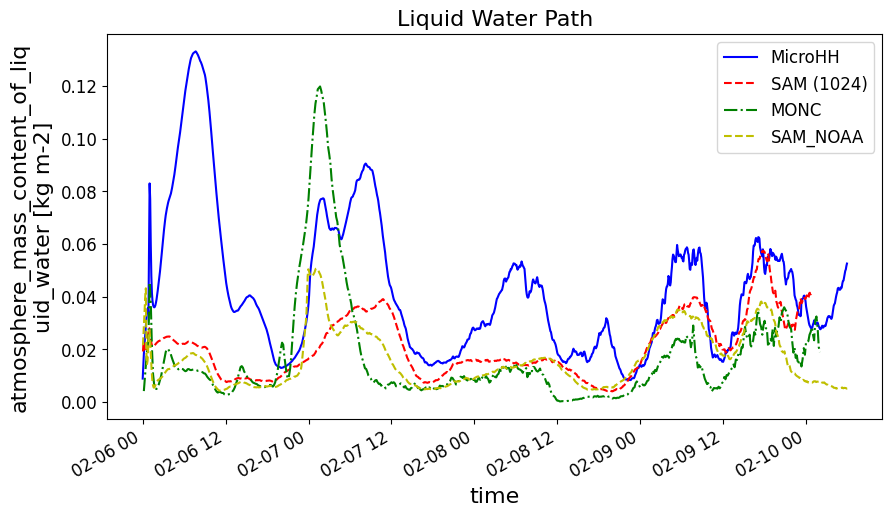

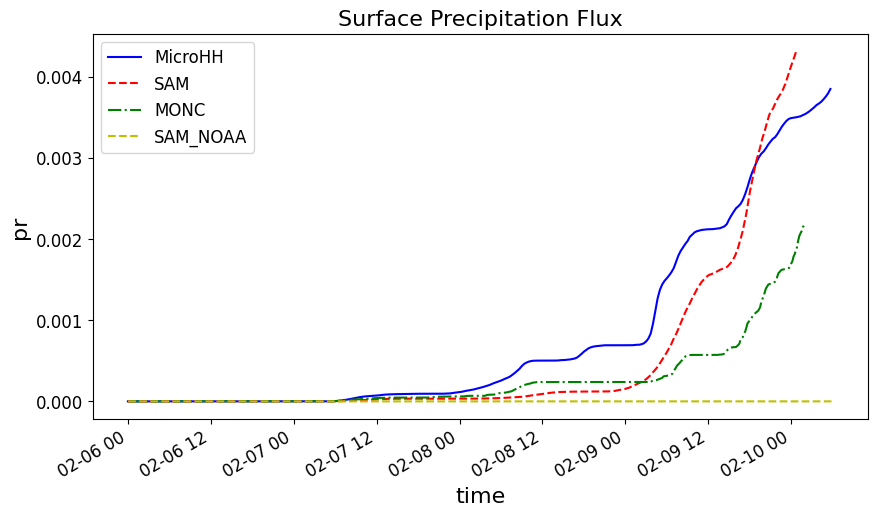

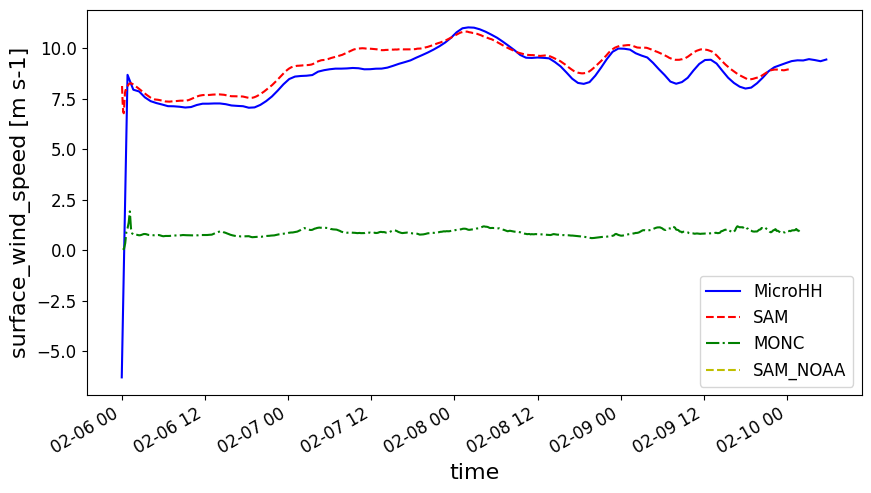

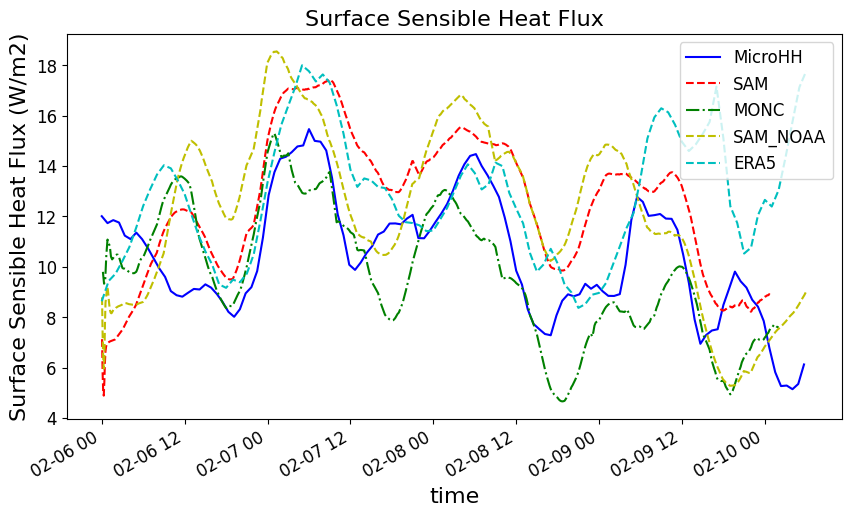

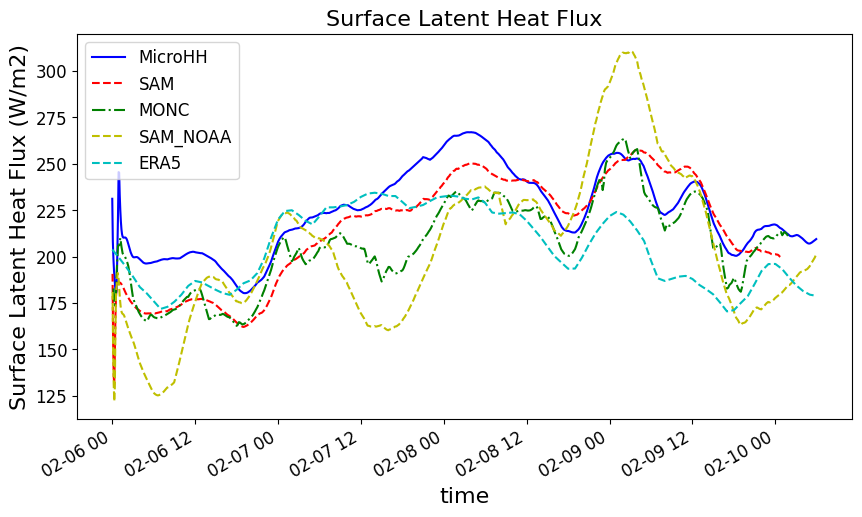

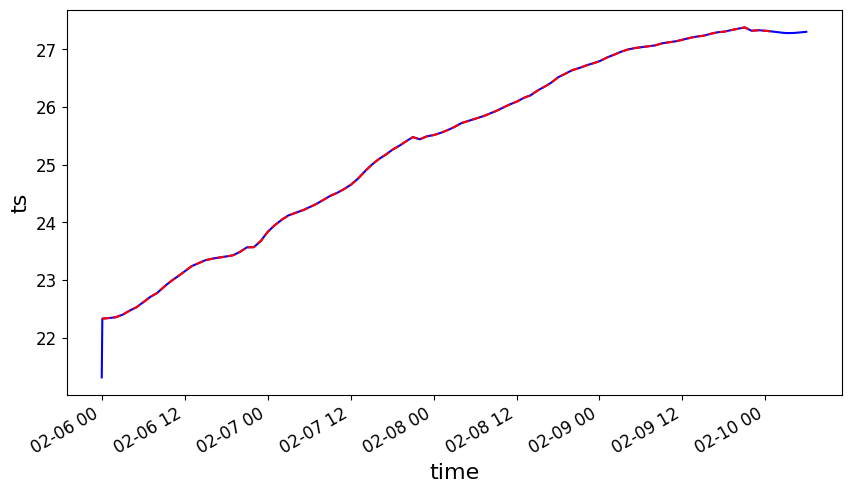

In [3]:
new_coords = xr.DataArray(SAM['zf'].values, dims='height')
SAM=SAM.assign_coords({'height':new_coords})

#### LWP #######
pl.figure(figsize=(10, 5))
MHH.lwp.plot.line('b-',label='MicroHH')
SAM['lwp'].plot.line('r--',label='SAM (1024)')
MONC['LWP_mean'].plot.line('g-.',label='MONC')
SAM_NOAA['lwp'].plot.line('y--',label='SAM_NOAA')
if plot_date=='Feb2':
    DALES['lwp_bar'].plot.line('k-.',label='DALES')
    MHH_w.lwp.plot.line('c--',label='MicroHH (1024, 8km top, no nudge)')
#MHH_eulerian.lwp.plot.line('b-.',label='MicroHH (Eulerian)')
pl.title('Liquid Water Path')
pl.legend()

#### Rain Rate #######
pl.figure(figsize=(10, 5))
MHH.rr.isel(time=slice(None,None,4)).cumsum().plot.line('b-',label='MicroHH')
SAM['pr'].cumsum().plot.line('r--',label='SAM')
MONC['surface_precip_mean'].cumsum().plot.line('g-.',label='MONC')
SAM_NOAA['pr'].cumsum().plot.line('y--',label='SAM_NOAA')
if  plot_date=='Feb2':
    MHH_w.pr.cumsum().plot.line('c--',label='MicroHH (1024, 8km top, no nudge)')
#if plot_date=='Feb2':
#    MHH_w.pr.isel(time=slice(None,None,10)).plot.line('b--',label='MicroHH (Jan 31 start)')
#(DALES1['rainrate']/2.5e8).isel(zt=0).plot.line('k-.',label='DALES')
#MHH_eulerian.lwp.plot.line('b-.',label='MicroHH (Eulerian)')
pl.title('Surface Precipitation Flux')
pl.legend()

#### Wind Speed #######
pl.figure(figsize=(10, 5))
MHH.wspd.isel(time=slice(None,None,10)).plot.line('b-',label='MicroHH')
SAM['wspd'].plot.line('r--',label='SAM')
((MONC['uu_mean']*MONC['vv_mean'])**(1/2)).isel(zn=0).plot.line('g-.',label='MONC')
SAM_NOAA['wspd'].plot.line('y--',label='SAM_NOAA')
if plot_date=='Feb2':
    MHH_w.wspd.isel(time=slice(None,None,1)).plot.line('b--',label='MicroHH (1024, 8km top, no nudge)')
    #DALES['lwp_bar'].plot.line('k-.',label='DALES')

#MHH_eulerian.lwp.plot.line('b-.',label='MicroHH (Eulerian)')
pl.legend()

#### Sensible Heat Flux #######
pl.figure(figsize=(10, 5))
MHH.hfss.isel(time=slice(None,None,10)).plot.line('b-',label='MicroHH')
SAM['hfss'].plot.line('r--',label='SAM')
MONC['senhf_mean'].plot.line('g-.',label='MONC')
if plot_date=='Feb2':
    DALES1['hfss']=DALES1['rhof'].isel(zt=0)*1004*DALES1['wthls'].isel(zm=0)
    DALES1['hfss'].plot.line('k-.',label='DALES')
    MHH_w.hfss.isel(time=slice(None,None,1)).plot.line('b--',label='MicroHH (1024, 8km top, no nudge)')
SAM_NOAA['hfss'].plot.line('y--',label='SAM_NOAA')
(ERA5['sfc_sens_flx']*-1).plot.line('c--',label='ERA5')
pl.ylabel('Surface Sensible Heat Flux (W/m2)')
#if plot_date=='Feb2':
#    MHH_w.hfss.isel(time=slice(None,None,1)).plot.line('b--',label='MicroHH (Jan 31 start)')
    #DALES['lwp_bar'].plot.line('k-.',label='DALES')
#MHH_eulerian.lwp.plot.line('b-.',label='MicroHH (Eulerian)')
pl.title('Surface Sensible Heat Flux')
pl.legend()

#### Sensible Latent Flux #######
pl.figure(figsize=(10, 5))
MHH.hfls.isel(time=slice(None,None,1)).plot.line('b-',label='MicroHH')
SAM['hfls'].plot.line('r--',label='SAM')
MONC['lathf_mean'].plot.line('g-.',label='MONC')

if plot_date=='Feb2':
    DALES1['hfls']=DALES1['rhof'].isel(zt=0)*DALES1['wqts'].isel(zm=0)*2500000
    DALES1['hfls'].plot.line('k-.',label='DALES')
    MHH_w.hfls.isel(time=slice(None,None,1)).plot.line('b--',label='MicroHH (1024, 8km top, no nudge)')
SAM_NOAA['hfls'].plot.line('y--',label='SAM_NOAA')
(ERA5['sfc_lat_flx']*-1).plot.line('c--',label='ERA5')
pl.ylabel('Surface Latent Heat Flux (W/m2)')
#if plot_date=='Feb2':
#    MHH_w.hfls.isel(time=slice(None,None,1)).plot.line('b--',label='MicroHH (Jan 31 start)')

#MHH_eulerian.lwp.plot.line('b-.',label='MicroHH (Eulerian)')
pl.title('Surface Latent Heat Flux')
pl.legend()


pl.figure(figsize=(10, 5))
(MHH['ts']-273).plot.line('b-',label='MicroHH')
(SAM['ts']-273).plot.line('r--',label='SAM')



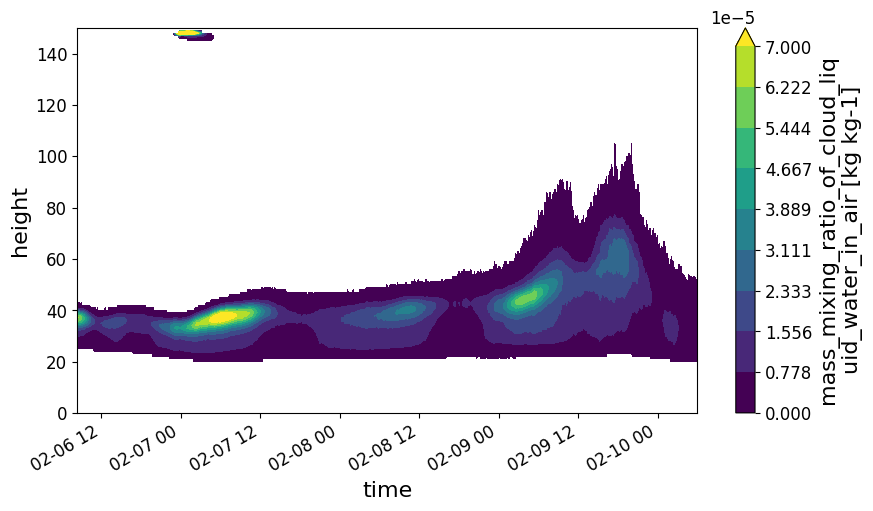

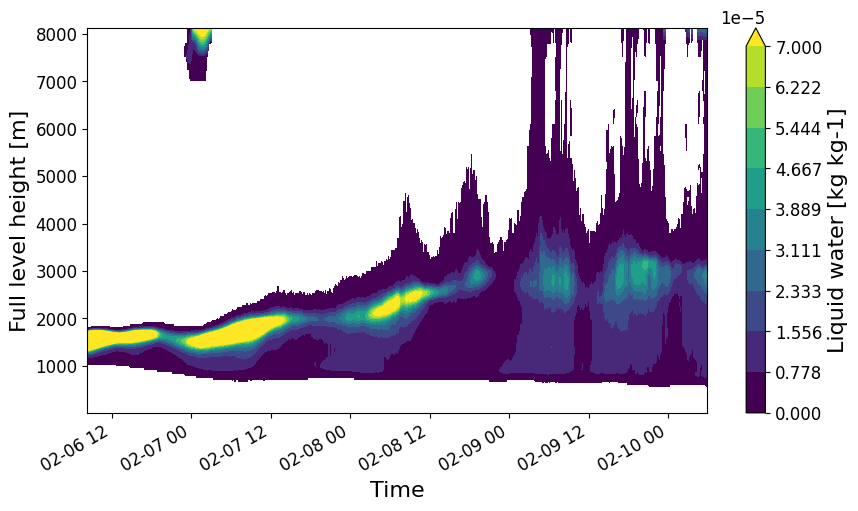

In [10]:
#pl.figure(figsize=(10, 5))
#(SAM_NOAA['qlc']>1e-6).plot()

pl.figure(figsize=(10, 5))
levs=np.linspace(0,7e-5,10)
SAM_NOAA['qlc']=SAM_NOAA['qlc'].where(SAM_NOAA.qlc>1e-7,np.nan)
SAM_NOAA.qlc.isel(time=slice(100,None)).plot.contourf(x='time',levels=levs)

pl.figure(figsize=(10, 5))
levs=np.linspace(0,7e-5,10)
MHH['qlc']=MHH['qlc'].where(MHH.qlc>1e-7,np.nan)
MHH.qlc.isel(time=slice(100,None)).plot.contourf(x='time',levels=levs)

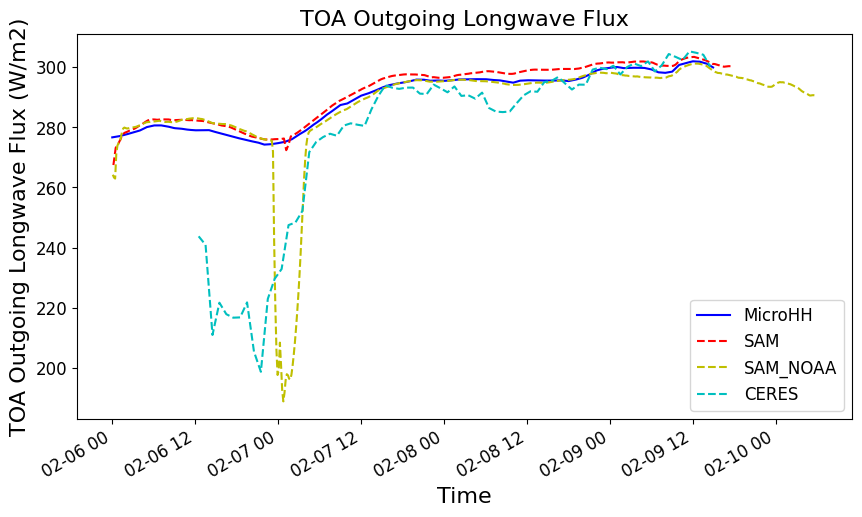

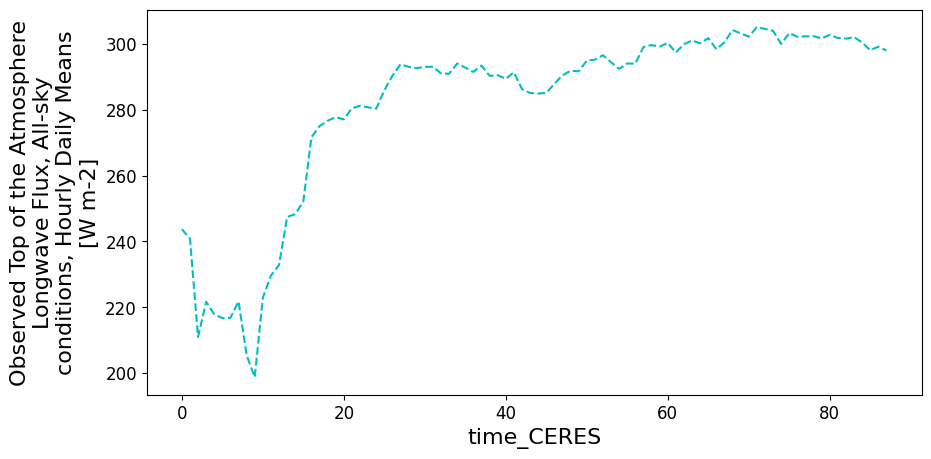

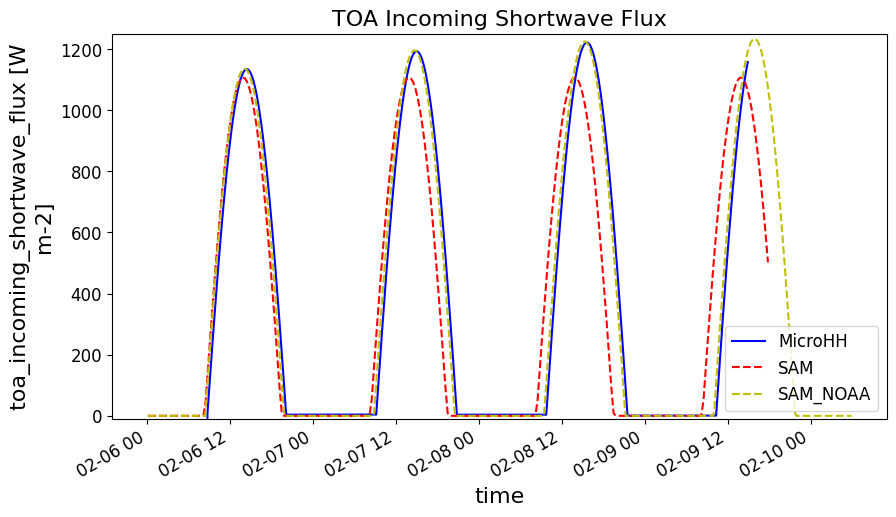

In [17]:
#### OLR #######
lead_time=12.5
pl.figure(figsize=(10, 5))
MHH['rlut'].isel(time=slice(None,None,1)).plot.line('b-',label='MicroHH')
SAM['rlut'].plot.line('r--',label='SAM')
SAM_NOAA['rlut'].plot.line('y--',label='SAM_NOAA')
MHH['ceres_rlut']=xr.DataArray(np.zeros(MHH['time'].size),dims=['time'])
MHH['ceres_rlut'].isel(time=slice(int(lead_time*12),int((lead_time+CERES['rlut'].size)*12),12)).values[:]=CERES['rlut'].values[:]
MHH['ceres_rlut'].isel(time=slice(int(lead_time*12),int((lead_time+CERES['rlut'].size)*12),12)).plot.line('c--',label='CERES')   
pl.title('TOA Outgoing Longwave Flux')
pl.ylabel('TOA Outgoing Longwave Flux (W/m2)')
pl.legend()


#### ISR #######
pl.figure(figsize=(10, 5))
MHH.rsdt.isel(time=slice(None,None,1)).plot.line('b-',label='MicroHH')
SAM['rsdt'].plot.line('r--',label='SAM')
#MONC['lathf_mean'].plot.line('g-.',label='MONC')
if plot_date=='Feb2':
    MHH_w.rsdt.isel(time=slice(None,None,1)).plot.line('b--',label='MicroHH (Jan 31 start)')
    (DALES['SW_dn_TOA']*-1).isel(time=slice(None,None,40)).plot.line('k-.',label='DALES')
    SAM_NOAA['rsdt'].plot.line('y--',label='SAM_NOAA')
elif plot_date=='Feb9':
    SAM_NOAA['rsdt'].plot.line('y--',label='SAM_NOAA')
#MHH_eulerian.lwp.plot.line('b-.',label='MicroHH (Eulerian)')
pl.title('TOA Incoming Shortwave Flux')
pl.ylim(-10,1250)
pl.legend()

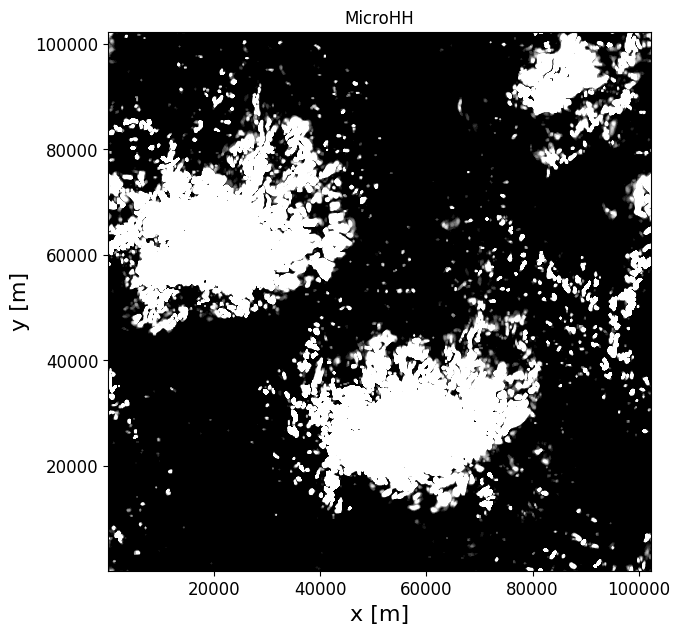

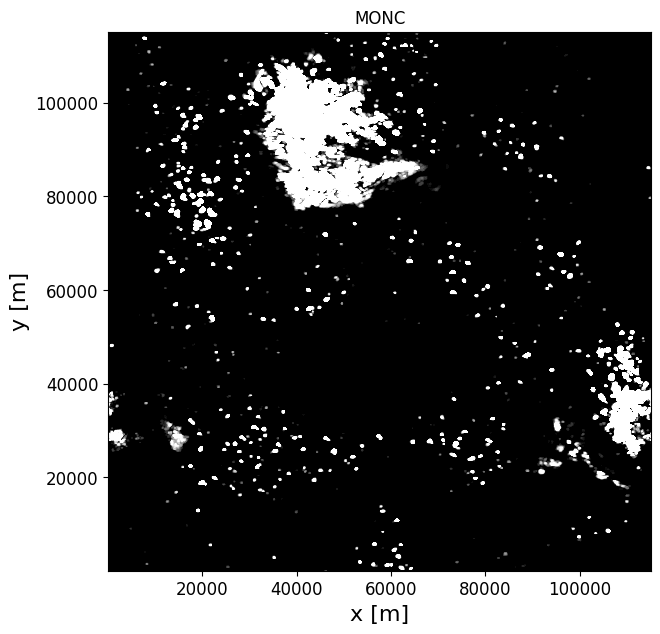

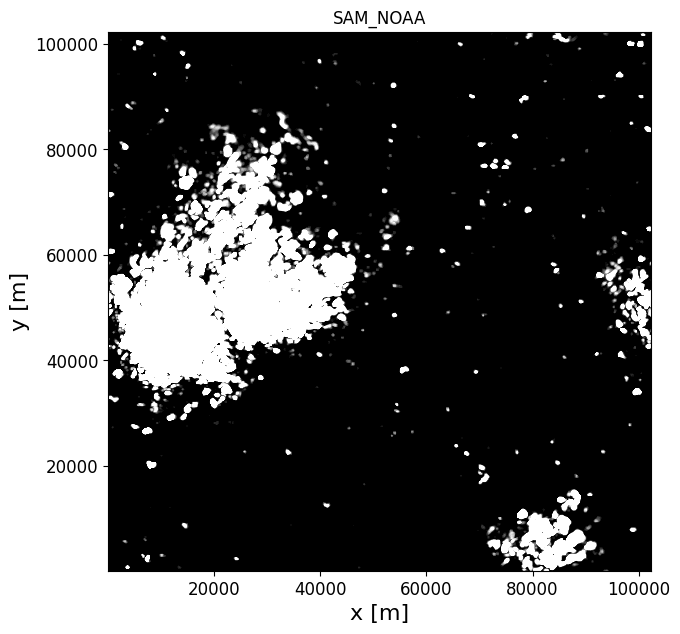

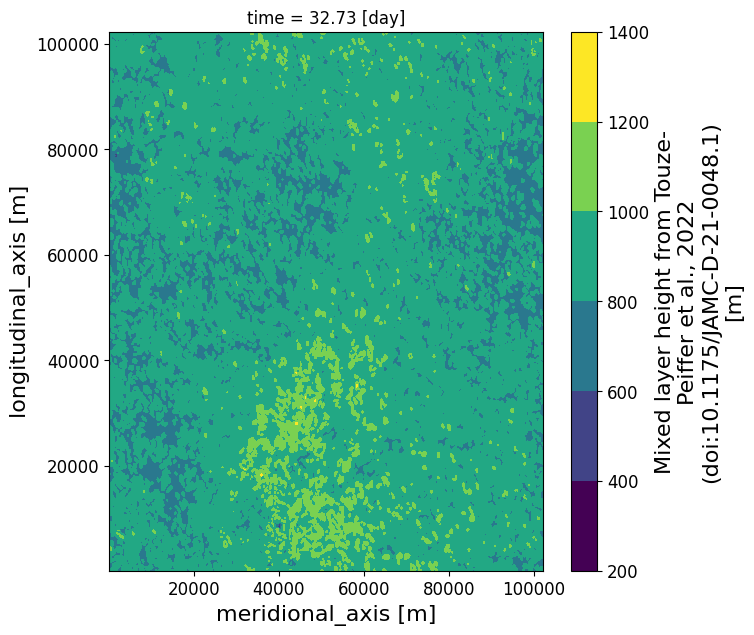

In [2]:
import matplotlib.pyplot as pl
import xarray as xr
import numpy as np

pl.rcParams['xtick.labelsize'] = 12
pl.rcParams['ytick.labelsize'] = 12
pl.rcParams['axes.labelsize'] = 16
levs=np.concatenate((np.linspace(0,0.01,20),np.linspace(0.011,1,1)))

MHH_2d=xr.open_dataset('/fs/ess/PFS0220/eurec4a/microhh_results/eurec4a_Feb2_512_200m_12kmtop_nudged6hr_2d_up.nc',decode_times=True)
MONC_2d=xr.open_dataset('/fs/ess/PFS0220/eurec4a/MONC_results/d20200202_diagnostic_2d.nc',decode_times=True)
SAM_NOAA_2d=xr.open_dataset('/fs/ess/PFS0220/eurec4a/SAM_NOAA_results/NOAA_SAM_EUREC4A_2020-02-02_512sqx153_200m_FY2M_RRTM_NA853.000_eurec4a_20200202.kpt_2D_1800s.nc',decode_times=True)

pl.figure(figsize=(7, 7))
MHH_2d['ql_path'].isel(time=int(89*3600/300)).plot.contourf(levels=levs,cmap='gray',add_colorbar=False)
pl.title('MicroHH')

pl.figure(figsize=(7, 7))
MONC_2d['lwp'].isel(time=int(65*3600/1800)).transpose().plot.contourf(levels=levs,cmap='gray',add_colorbar=False)
pl.xlabel('x [m]')
pl.ylabel('y [m]')
pl.title('MONC')

pl.figure(figsize=(7, 7))
SAM_NOAA_2d['CWP'].isel(time=int(65*3600/1800)).plot.contourf(levels=levs,cmap='gray',add_colorbar=False)
pl.xlabel('x [m]')
pl.ylabel('y [m]')
pl.title('SAM_NOAA')

pl.figure(figsize=(7, 7))
SAM_NOAA_2d['HMIX'].isel(time=int(65*3600/1800)).transpose().plot.contourf()



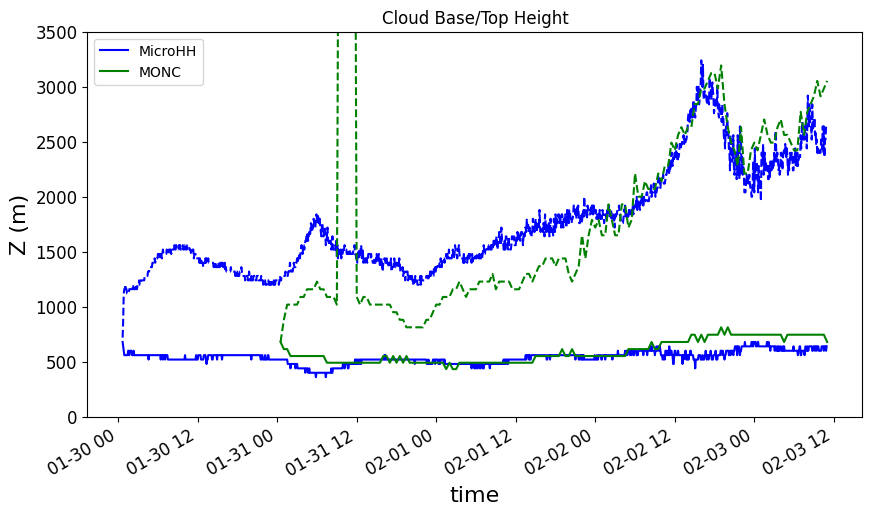

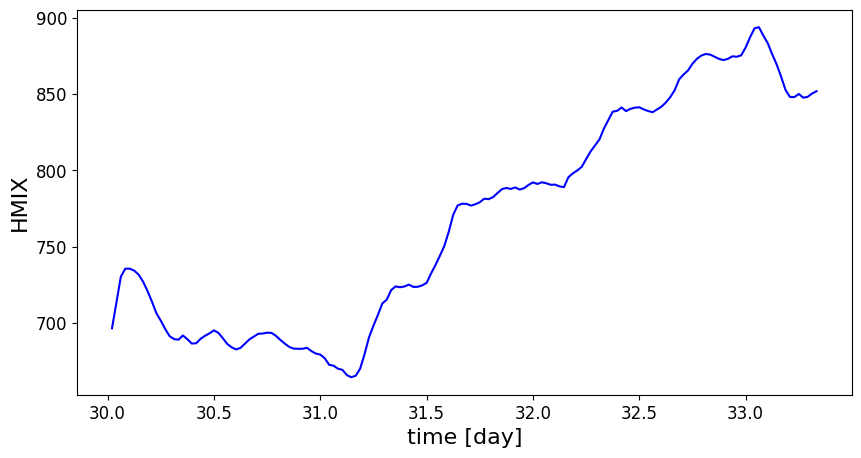

In [4]:
pl.figure(figsize=(10, 5))
MHH_2d['ql_base'].where(MHH_2d['ql_base']>0).min(dim=['x','y']).plot.line('b-',label='MicroHH')    
MHH_2d['ql_top'].where(MHH_2d['ql_top']>0).max(dim=['x','y']).plot.line('b--')  


MONC_2d['clbas'].where(MONC_2d['clbas']>0).min(dim=['x','y']).plot.line('g-',label='MONC')    
MONC_2d['cltop'].where(MONC_2d['cltop']>0).max(dim=['x','y']).plot.line('g--')


pl.legend()
pl.ylabel('Z (m)')
pl.title('Cloud Base/Top Height')
pl.ylim(0,3500)

pl.figure(figsize=(10, 5))
MONC_2d['HMIX'].mean(dim=['x','y']).plot.line('b-',label='MicroHH')

Text(0.5, 1.0, 'MicroHH')

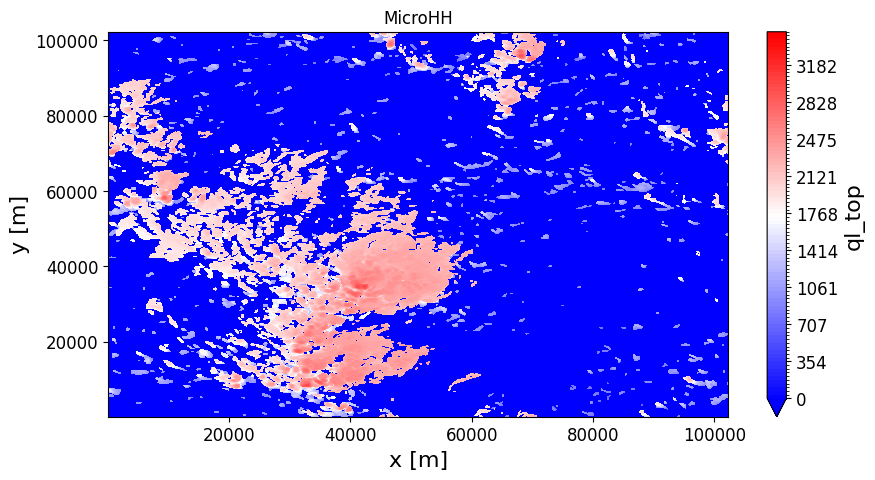

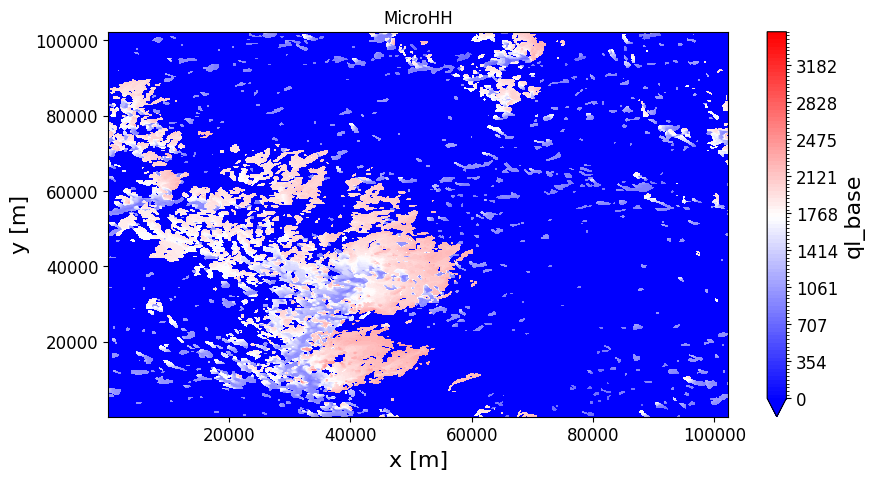

In [24]:
pl.figure(figsize=(10, 5))
MHH_2d['ql_top'].isel(time=int(66*3600/300)).plot.contourf(levels=np.linspace(0,3500,100),cmap='bwr')
pl.title('MicroHH')

pl.figure(figsize=(10, 5))
MHH_2d['ql_base'].isel(time=int(66*3600/300)).plot.contourf(levels=np.linspace(0,3500,100),cmap='bwr')
pl.title('MicroHH')

In [ ]:
import datetime
import numpy as np
import eurec4a
%matplotlib inline
import matplotlib.pyplot as plt
import pathlib
plt.style.use(pathlib.Path("./mplstyle/book"))

def dt64_to_dt(dt64):
    epoch = np.datetime64('1970-01-01T00:00:00')
    second = np.timedelta64(1, 's')
    return datetime.datetime.utcfromtimestamp(int((dt64 - epoch) / second))

fig, (ax0, ax1) = plt.subplots(1, 2)

y = ds_sondes_first_circle_Feb05.alt

x0 = ds_sondes_first_circle_Feb05.ta.transpose("alt", "sonde_id")
ax0.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(dropsonde_ids))))
ax0.plot(x0, y.data[:, np.newaxis])
ax0.set_xlabel(f"{x0.long_name} / {x0.units}")
ax0.set_ylabel(f"{y.name} / m")
ax0.legend([dt64_to_dt(d).strftime("%H:%M:%S")
            for d in ds_sondes_first_circle_Feb05.launch_time],
           title=x0.launch_time.name)

x1 = ds_sondes_first_circle_Feb05.rh.transpose("alt", "sonde_id")
ax1.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(dropsonde_ids))))
ax1.plot(x1, y.data[:, np.newaxis])
ax1.set_xlabel(f"{x1.long_name} / {x1.units}")
ax1.set_ylabel(f"{y.name} / m")
ax1.legend(ds_sondes_first_circle_Feb05.sonde_id.values,
           title="sonde_id")

fig.suptitle('Dropsondes from 1st circle an February 5', fontsize=18)